# Prepare matrices for MOFA

In [1]:
here::i_am("rna_atac/mofa/01_prepare_mofa.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code



In [2]:
io$basedir

[1] "/rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood"

In [3]:
args = list()
# ATAC
args$atac_metadata = file.path(io$basedir, 'results/atac/archR/qc/sample_metadata_update_PeakClusters.txt.gz')
args$atac_matrix = file.path(io$basedir, 'processed/atac/archR/Matrices/PeakMatrix_summarized_experiment.rds')
args$atac_feature_stats = file.path(io$basedir, 'results/atac/archR/feature_stats/PeakMatrix/PeakMatrix_Clusters_PeakMatrix2_stats.txt.gz')
args$atac_nfeatures = 25000
# RNA
args$rna_metadata = file.path(io$basedir, 'results/rna/doublet_detection/sample_metadata_after_doublets.txt.gz')
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')
args$rna_nfeatures = 4000
# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/mofa/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [4]:
##########################
## Load sample metadata ##
##########################

metadata_atac <- fread(args$atac_metadata) %>%
  .[pass_atacQC==TRUE & doublet_call==FALSE | pass_atacQC==TRUE & is.na(doublet_call)]

metadata_rna <- fread(args$rna_metadata) %>%
  .[pass_rnaQC==TRUE & doublet_call==FALSE]

cells_keep = intersect(metadata_atac$cell, metadata_rna$cell)
metadata_atac = metadata_atac[match(cells_keep, cell)]
metadata_rna = metadata_rna[match(cells_keep, cell)]

# metadata_atac contains all info from RNA as well as ATAC
sample_metadata = metadata_atac

In [5]:
####################
## Load ATAC data ##
####################
atac.se <- readRDS(args$atac_matrix)[,sample_metadata$cell]

# non_binarized, might work better on binarized data though

In [6]:
#########################
## ATAC pre-processing ##
#########################

# Define highly variable features
atac_features <- fread(args$atac_feature_stats) %>% 
  setorder(-var_pseudobulk) %>% 
  head(n=args$atac_nfeatures) %>% .$feature

# Normalisation & Feature selection
atac_tfidf.mtx <- tfidf(assay(atac.se[atac_features,]), method=1, scale.factor=1e4) %>% round(2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     77    1353    2566    3608    4930   25587 

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


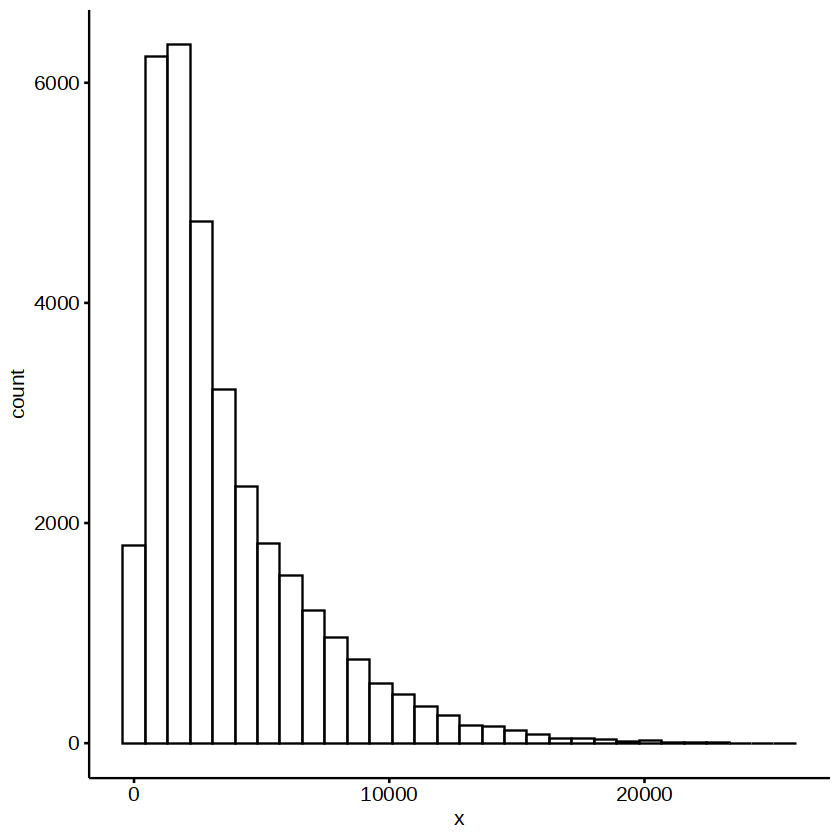

In [7]:
summary(colSums(atac.se[atac_features,]@assays@data$PeakMatrix))
options(repr.plot.heigth=5)
gghistogram(colSums(atac.se[atac_features,]@assays@data$PeakMatrix))

In [8]:
##############################
## Load RNA expression data ##
##############################

rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = sample_metadata$cell)

# Add sample metadata to the colData of the SingleCellExperiment
colData(rna.sce) <- sample_metadata %>% as.data.frame %>% tibble::column_to_rownames("cell") %>%
  .[colnames(rna.sce),] %>% DataFrame()

# Filter features manually
rna.sce <- rna.sce[grep("*Rik|^Gm|^Mt-|^Rps|^Rpl|^Olfr",rownames(rna.sce), invert=T),]

# Feature selection
rna_features <- modelGeneVar(rna.sce) %>% as.data.table(keep.rownames = T) %>%
  setnames("rn","gene") %>%
  .[mean>=0.001] %>% setorder(FDR) %>% head(args$rna_nfeatures) %>% .$gene

# Fetch matrix
rna.mtx <- assay(rna.sce[rna_features,],"logcounts") %>% round(2)
dim(rna.mtx)

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”


[1]  4000 33177

In [9]:
###############
## Save data ##
###############
Matrix::writeMM(rna.mtx, file.path(args$outdir,"rna.mtx"))
Matrix::writeMM(atac_tfidf.mtx, file.path(args$outdir,"atac_tfidf.mtx"))
write.table(rownames(rna.mtx), file.path(args$outdir,"rna_features.txt"), quote=F, row.names=F, col.names=F)
write.table(rownames(atac_tfidf.mtx), file.path(args$outdir,"atac_features.txt"), quote=F, row.names=F, col.names=F)
write.table(sample_metadata$cell, file.path(args$outdir,"cells.txt"), quote=F, row.names=F, col.names=F)
fwrite(sample_metadata, file.path(args$outdir,"sample_metadata.txt.gz"))

NULL

NULL

In [10]:
atac.se.bin = atac.se[atac_features,]

In [11]:
atac.mtx = as.matrix(atac.se.bin@assays@data$PeakMatrix)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.2 GiB”


In [12]:
atac.mtx[atac.mtx>0] = 1

In [13]:
atac.mtx_sparse = as(atac.mtx, "dgCMatrix")

In [14]:
atac_tfidf.mtx.bin <- tfidf(atac.mtx_sparse, method=1, scale.factor=1e4) %>% round(2)

In [15]:
Matrix::writeMM(atac_tfidf.mtx.bin, file.path(args$outdir,"atac_tfidf_binarized.mtx"))

NULL